In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder

In [0]:
train=pd.read_csv('train_v9rqX0R.csv')
test=pd.read_csv('test_AbJTz2l.csv')
train.shape, train.columns, test.shape, test.columns

((8523, 12),
 Index(['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
        'Item_Type', 'Item_MRP', 'Outlet_Identifier',
        'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
        'Outlet_Type', 'Item_Outlet_Sales'],
       dtype='object'),
 (5681, 11),
 Index(['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
        'Item_Type', 'Item_MRP', 'Outlet_Identifier',
        'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
        'Outlet_Type'],
       dtype='object'))

In [0]:
train['source_type']='train'
test['source_type']='test'
test['Item_Outlet_Sales']='NA'
df_total=pd.concat([train, test],ignore_index=True)

In [0]:
df_total.isnull().sum()

Item_Identifier                 0
Item_Weight                  2439
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  4016
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
source_type                     0
dtype: int64

/home/spark-4958e8d6-1b48-4a21-8a5c-78/.ipykernel/1890/command-7681106383959381-998481826:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=item_identifier_wise_sales.index[:20],y=item_identifier_wise_sales.values[:20], ci=None, palette='pastel')


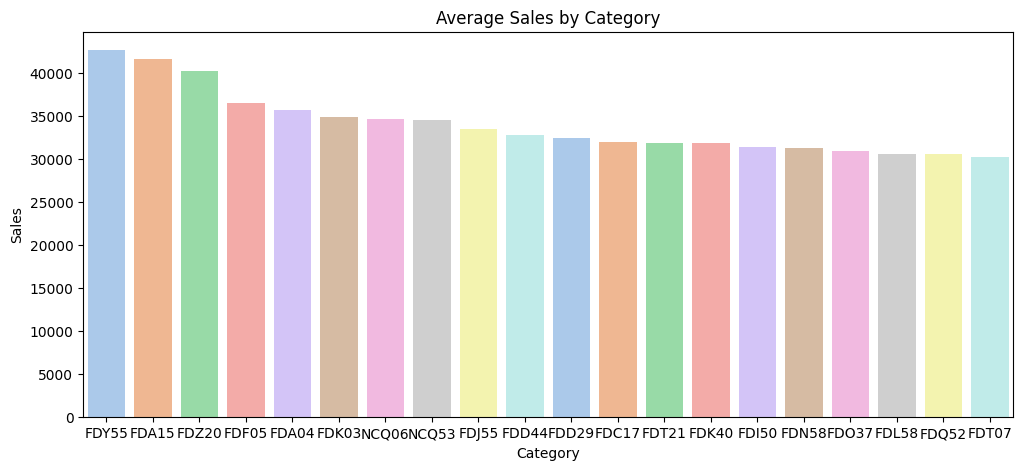

In [0]:
item_identifier_wise_sales=train.groupby('Item_Identifier')['Item_Outlet_Sales'].sum().sort_values(ascending=False)

plt.figure(figsize=(12, 5))
# Bar plot (aggregates mean by default)
sns.barplot(x=item_identifier_wise_sales.index[:20],y=item_identifier_wise_sales.values[:20], ci=None, palette='pastel')
plt.title("Average Sales by Category")
plt.xlabel("Category")
plt.ylabel("Sales")
plt.show()

In [0]:
df_total['Item_Identifier'].str[:2].value_counts()

FD    10201
NC     2686
DR     1317
Name: Item_Identifier, dtype: int64

In [0]:
df_total['Item_Identifier_transformed']=df_total['Item_Identifier'].apply(lambda x: 1 if x[:2]=='DR' else 2 if x[:2]=='NC' else 3)

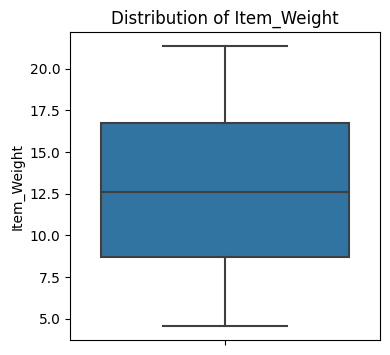

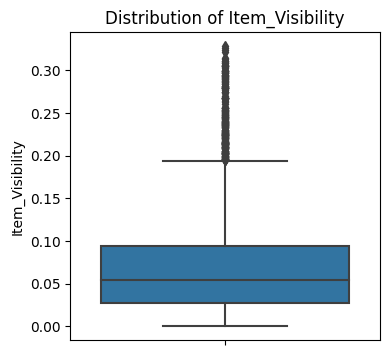

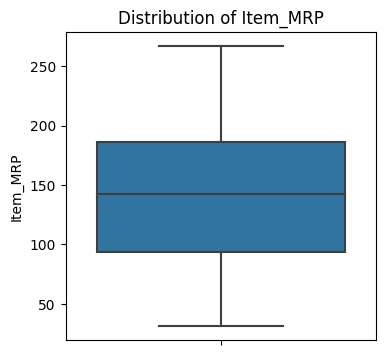

In [0]:
# Multiple boxplots side by side
for col in ['Item_Weight', 'Item_Visibility', 'Item_MRP']:
    plt.figure(figsize=(4, 4))
    # Boxplot (vertical)
    sns.boxplot(y=df_total[col])
    plt.title(f"Distribution of {col}")
    plt.ylabel(col)
    plt.show()

Pandas skewness: 1.1951751774587882


/databricks/python/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


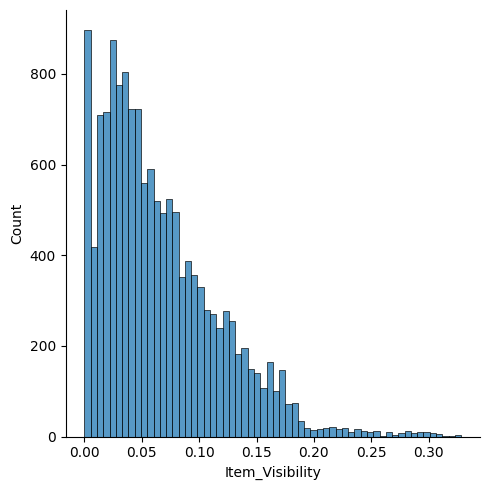

In [0]:
print("Pandas skewness:", df_total['Item_Visibility'].skew())
sns.displot(df_total.Item_Visibility)

In [0]:
#df_total['Item_Visibility']=np.log1p(df_total['Item_Visibility'])

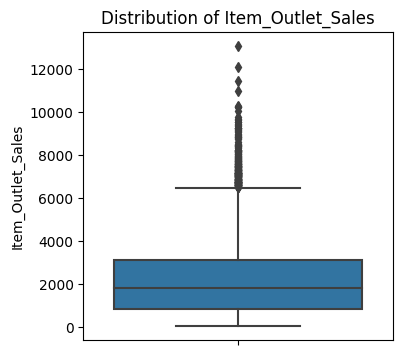

In [0]:
# Multiple boxplots side by side
for col in ['Item_Outlet_Sales']:
    plt.figure(figsize=(4, 4))
    # Boxplot (vertical)
    sns.boxplot(y=train[col])
    plt.title(f"Distribution of {col}")
    plt.ylabel(col)
    plt.show()

Pandas skewness: 1.1775306028542796
count     8523.000000
mean      2181.288914
std       1706.499616
min         33.290000
25%        834.247400
50%       1794.331000
75%       3101.296400
max      13086.964800
Name: Item_Outlet_Sales, dtype: float64


/databricks/python/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


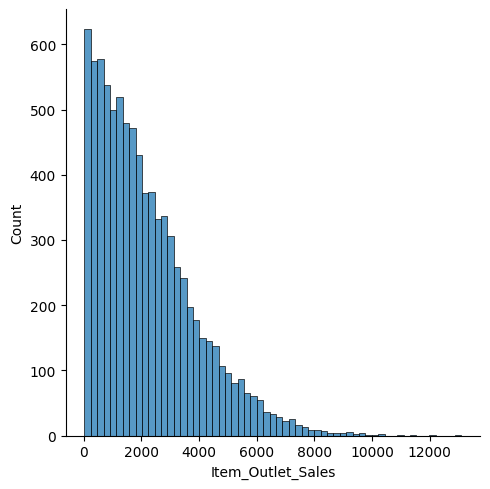

In [0]:
print(f"Pandas skewness: {train['Item_Outlet_Sales'].skew()}",  train['Item_Outlet_Sales'].describe(), sep='\n')
sns.displot(train.Item_Outlet_Sales)

In [0]:
outlier_idxs=[]

for i in range(df_total.shape[0]):
    if df_total['source_type'][i]=='train':
        if df_total['Item_Outlet_Sales'][i]>12000:
            outlier_idxs.append(i)

df_total=df_total.drop(index=outlier_idxs).reset_index(drop=True)

In [0]:
#train['target_transformed']=np.log1p(train['Item_Outlet_Sales'])

In [0]:
df_total['Item_Visibility']=df_total['Item_Visibility'].apply(lambda x: df_total['Item_Visibility'].median() if x==0 else x)

In [0]:
for i in ['Item_Fat_Content', 'Item_Type', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type']:
    print(df_total[i].value_counts(), end='\n\n')

Low Fat    8484
Regular    4823
LF          522
reg         195
low fat     178
Name: Item_Fat_Content, dtype: int64

Fruits and Vegetables    2012
Snack Foods              1989
Household                1547
Frozen Foods             1426
Dairy                    1136
Baking Goods             1086
Canned                   1084
Health and Hygiene        858
Meat                      736
Soft Drinks               726
Breads                    416
Hard Drinks               362
Others                    280
Starchy Foods             269
Breakfast                 186
Seafood                    89
Name: Item_Type, dtype: int64

Medium    4653
Small     3980
High      1553
Name: Outlet_Size, dtype: int64

Tier 3    5581
Tier 2    4641
Tier 1    3980
Name: Outlet_Location_Type, dtype: int64

Supermarket Type1    9294
Grocery Store        1805
Supermarket Type3    1557
Supermarket Type2    1546
Name: Outlet_Type, dtype: int64



In [0]:
mode_of_Outlet_size=df_total.pivot_table(values='Outlet_Size', columns='Outlet_Type', aggfunc=(lambda x: x.mode()[0]))
df_total.loc[df_total['Outlet_Size'].isnull(), 'Outlet_Size']=df_total.loc[df_total['Outlet_Size'].isnull(),'Outlet_Type'].apply(lambda x: mode_of_Outlet_size[x])

In [0]:
median_weight=pd.concat([df_total['Item_Weight'], test['Item_Weight']]).median()
df_total['Item_Weight'].fillna(median_weight, inplace=True)

In [0]:
df_total.loc[df_total['Item_Identifier_transformed']==2,'Item_Fat_Content'].unique()

array(['Low Fat', 'low fat', 'LF'], dtype=object)

In [0]:
df_total['Item_Fat_Content'].replace({'low fat':2, 'LF': 2, 'Low Fat': 2, 'reg':3, 'Regular':3}, inplace = True)
df_total.loc[df_total['Item_Identifier_transformed']==2,'Item_Fat_Content'] = 1
df_total['Item_Fat_Content'].unique()

array([2, 3, 1])

In [0]:
corr, p_value = pearsonr(train['Outlet_Establishment_Year'], train['Item_Outlet_Sales'])
print("Pearson correlation:", corr)
print("p-value:", p_value)

Pearson correlation: -0.049134970440820866
p-value: 5.673082108322114e-06


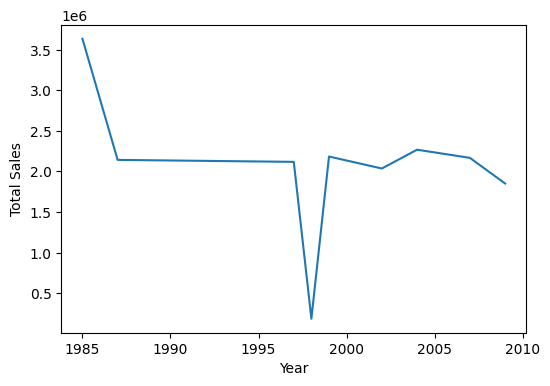

In [0]:
yearwise_sales = train.groupby('Outlet_Establishment_Year')['Item_Outlet_Sales'].sum()
plt.figure(figsize=(6, 4))
sns.lineplot(x=yearwise_sales.index, y=yearwise_sales.values)
plt.xlabel('Year')
plt.ylabel('Total Sales')
plt.show()

In [0]:
# creating new column num_years
df_total['num_years'] = df_total['Outlet_Establishment_Year'].apply(lambda x: x-df_total['Outlet_Establishment_Year'].min()) 
df_total.drop(columns=['Outlet_Establishment_Year'], inplace=True)

In [0]:
# # handling catagorical variables
# train_encoded=pd.get_dummies(train, columns = ['Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type'], drop_first = True)
# test_encoded=pd.get_dummies(test, columns = ['Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type'], drop_first = True)

In [0]:
# Columns you want to encode
cat_cols = ['Item_Type', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type']

# Create the encoder
oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

# Fit on train and transform both df
df_total[cat_cols] = oe.fit_transform(df_total[cat_cols])
df_total_encoded=df_total.copy()
train_encoded=df_total_encoded[df_total_encoded['source_type']=='train'].reset_index(drop=True)
test_encoded=df_total_encoded[df_total_encoded['source_type']=='test'].reset_index(drop=True)

In [0]:
train_encoded.columns

Index(['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
       'Item_Type', 'Item_MRP', 'Outlet_Identifier', 'Outlet_Size',
       'Outlet_Location_Type', 'Outlet_Type', 'Item_Outlet_Sales',
       'source_type', 'Item_Identifier_transformed', 'num_years'],
      dtype='object')

In [0]:
# input_cols=['Item_Identifier_transformed', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility', 'Item_MRP', 'num_years', 'Item_Type_Breads', 'Item_Type_Breakfast', 'Item_Type_Canned', 'Item_Type_Dairy', 'Item_Type_Frozen Foods', 'Item_Type_Fruits and Vegetables', 'Item_Type_Hard Drinks', 'Item_Type_Health and Hygiene', 'Item_Type_Household', 'Item_Type_Meat', 'Item_Type_Others', 'Item_Type_Seafood', 'Item_Type_Snack Foods', 'Item_Type_Soft Drinks', 'Item_Type_Starchy Foods', 'Outlet_Size_Medium', 'Outlet_Size_Small', 'Outlet_Location_Type_Tier 2', 'Outlet_Location_Type_Tier 3', 'Outlet_Type_Supermarket Type1', 'Outlet_Type_Supermarket Type2', 'Outlet_Type_Supermarket Type3']

input_cols=['Item_Weight', 'Item_Fat_Content', 'Item_Visibility', 'Item_Type', 'Item_MRP', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type', 'Item_Identifier_transformed', 'num_years'] 

In [0]:
x_train=train_encoded[input_cols]
y_train=train_encoded['Item_Outlet_Sales'] #target_transformed
x_test=test_encoded[input_cols]

In [0]:
x_train.corr()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Identifier_transformed,num_years
Item_Weight,1.000000,-0.039611,-0.015007,0.028044,0.025056,-0.012139,0.001150,-0.013592,0.016718,0.013939
Item_Fat_Content,-0.039611,1.000000,0.066596,-0.196193,0.001462,-0.001526,-0.004338,0.004421,0.500429,0.004411
Item_Visibility,-0.015007,0.066596,1.000000,-0.035235,-0.000932,0.093880,-0.027840,-0.173042,0.055610,-0.075238
Item_Type,0.028044,-0.196193,-0.035235,1.000000,0.032642,-0.000208,0.003068,0.003021,-0.329561,0.004995
Item_MRP,0.025056,0.001462,-0.000932,0.032642,1.000000,0.001117,-0.000170,-0.002810,0.043585,0.005588
Outlet_Size,-0.012139,-0.001526,0.093880,-0.000208,0.001117,1.000000,-0.479997,-0.401282,-0.004223,0.425435
Outlet_Location_Type,0.001150,-0.004338,-0.027840,0.003068,-0.000170,-0.479997,1.000000,0.466985,0.001350,-0.088861
Outlet_Type,-0.013592,0.004421,-0.173042,0.003021,-0.002810,-0.401282,0.466985,1.000000,0.011292,-0.121598
Item_Identifier_transformed,0.016718,0.500429,0.055610,-0.329561,0.043585,-0.004223,0.001350,0.011292,1.000000,-0.005909
num_years,0.013939,0.004411,-0.075238,0.004995,0.005588,0.425435,-0.088861,-0.121598,-0.005909,1.000000


In [0]:
# XGBRegressor model
xgb_model = XGBRegressor(random_state=42)

# Hyperparameters to tune
xgb_param_grid = {
    'n_estimators': [30, 50, 100], 
    'max_depth': [3, 4, 5],             
    'learning_rate': [0.05, 0.1, 0.3],
    'reg_lambda': [5, 7],   # L2 regularization
    'reg_alpha': [5, 7]     # L1 regularization
}

# Grid search with 5-fold CV
xgb_grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=xgb_param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=1,
    n_jobs=-1
)

In [0]:
# Run grid search
xgb_grid_search.fit(x_train, y_train)

# Results
print("Best Parameters:", xgb_grid_search.best_params_)
print("Best -MSE:", xgb_grid_search.best_score_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'reg_alpha': 7, 'reg_lambda': 5}
Best -MSE: -1155987.9543680123


In [0]:
best_xgb = xgb_grid_search.best_estimator_

# Get feature importances
importances = best_xgb.feature_importances_

# If you want a nice dataframe with feature names
feature_importance_df = pd.DataFrame({
    'Feature': x_train.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

feature_importance_df

,Feature,Importance
7,Outlet_Type,0.456505
4,Item_MRP,0.414175
9,num_years,0.029226
6,Outlet_Location_Type,0.027254
5,Outlet_Size,0.021023
1,Item_Fat_Content,0.015727
3,Item_Type,0.015297
0,Item_Weight,0.009837
2,Item_Visibility,0.008784
8,Item_Identifier_transformed,0.002171


In [0]:
# Predict directly with the best fitted model
xgb_y_pred = xgb_grid_search.best_estimator_.predict(x_test)
#y_pred_original = np.expm1(y_pred)
xgb_submission=test[['Item_Identifier', 'Outlet_Identifier']].copy()
xgb_submission['Item_Outlet_Sales']=xgb_y_pred
len(xgb_y_pred), x_test.shape, xgb_submission.shape, xgb_submission.columns

(5681,
 (5681, 10),
 (5681, 3),
 Index(['Item_Identifier', 'Outlet_Identifier', 'Item_Outlet_Sales'], dtype='object'))

In [0]:
# LightGBM model
lgb_model = LGBMRegressor(random_state=42)

# Hyperparameters to tune
lgb_param_grid = {
    'n_estimators': [50, 100]
}

# Grid search with 5-fold CV
lgb_grid_search = GridSearchCV(
    estimator=lgb_model,
    param_grid=lgb_param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=1,
    n_jobs=-1,
    error_score="raise"
)

In [0]:
# Run grid search
lgb_grid_search.fit(x_train, y_train.astype('float32'))

# Results
print("Best Parameters:", lgb_grid_search.best_params_)
print("Best -MSE:", lgb_grid_search.best_score_)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006783 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 781
[LightGBM] [Info] Number of data points in the train set: 8521, number of used features: 10
[LightGBM] [Info] Start training from score 2178.842964
Best Parameters: {'n_estimators': 50}
Best -MSE: -1204835.0089075249


In [0]:
# Predict directly with the best fitted model
lgb_y_pred = lgb_grid_search.best_estimator_.predict(x_test)
#y_pred_original = np.expm1(y_pred)
lgb_submission=test[['Item_Identifier', 'Outlet_Identifier']].copy()
lgb_submission['Item_Outlet_Sales']=lgb_y_pred
len(lgb_y_pred), x_test.shape, lgb_submission.shape, lgb_submission.columns

(5681,
 (5681, 10),
 (5681, 3),
 Index(['Item_Identifier', 'Outlet_Identifier', 'Item_Outlet_Sales'], dtype='object'))

In [0]:
# RandomForest model
rf_model = RandomForestRegressor(random_state=42)

# Hyperparameters to tune
rf_param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [4, 8, 12, None],
    'min_samples_leaf': [1, 2, 4]
}

# Grid search with 5-fold CV
rf_grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=rf_param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=1,
    n_jobs=-1
)

In [0]:
# Run grid search
rf_grid_search.fit(x_train, y_train)

# Results
print("Best Parameters:", rf_grid_search.best_params_)
print("Best -MSE:", rf_grid_search.best_score_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Parameters: {'max_depth': 8, 'min_samples_leaf': 4, 'n_estimators': 100}
Best -MSE: -1179584.1056160184


In [0]:
# Predict directly with the best fitted model
rf_y_pred = rf_grid_search.best_estimator_.predict(x_test)
#y_pred_original = np.expm1(y_pred)
rf_submission=test[['Item_Identifier', 'Outlet_Identifier']].copy()
rf_submission['Item_Outlet_Sales']=rf_y_pred
len(rf_y_pred), x_test.shape, rf_submission.shape, rf_submission.columns

(5681,
 (5681, 10),
 (5681, 3),
 Index(['Item_Identifier', 'Outlet_Identifier', 'Item_Outlet_Sales'], dtype='object'))

In [0]:
submission=test[['Item_Identifier', 'Outlet_Identifier']].copy()
submission['Item_Outlet_Sales']=(xgb_submission['Item_Outlet_Sales']+lgb_submission['Item_Outlet_Sales']+rf_submission['Item_Outlet_Sales'])/3

In [0]:
#xgb_submission.to_csv('bigmart_sales_xgb_v25.csv', index=False)